In [1]:
import torch
from torchvision import datasets, transforms

cifar = datasets.CIFAR10("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(28), transforms.Grayscale()]))

Files already downloaded and verified


In [2]:
cifar_loader = torch.utils.data.DataLoader(cifar, batch_size=len(cifar))

In [3]:
cifar_data = next(iter(cifar_loader))[0]

In [4]:
cifar_data.shape

torch.Size([50000, 1, 28, 28])

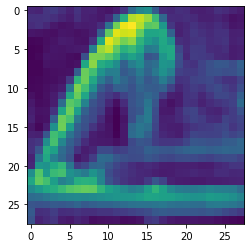

In [5]:
import matplotlib.pyplot as plt
plt.imshow(cifar_data[400].permute(1, 2, 0))
plt.show()

In [6]:
CIFAR_MEAN = cifar_data.mean()
CIFAR_STD = cifar_data.std()
CIFAR_MEAN, CIFAR_STD

(tensor(0.4809), tensor(0.2333))

In [7]:
import torch
from torchvision import datasets, transforms

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10("data", train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(28), transforms.Grayscale(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
    ])), batch_size=128, shuffle=True, num_workers=32)

val_loader = torch.utils.data.DataLoader(datasets.CIFAR10("data", train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(28), transforms.Grayscale(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
    ])), batch_size=128, shuffle=False, num_workers=32)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
import pytorch_lightning as pl
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from optimizee.cifar import CIFAR10Model


class CIFAR10Classifier(pl.LightningModule):
    def __init__(self, lr=1e-3, optimizer="adam"):
        super().__init__()
        self.save_hyperparameters()
        self.model = CIFAR10Model()
        self.criterion = nn.NLLLoss()
        self.metrics = {
            "accuracy": {
                "train": torchmetrics.Accuracy(),
                "val": torchmetrics.Accuracy()
            }
        }

    def step(self, batch, step_name="train"):
        X, y = batch
        outputs = self.model(X)
        loss = self.criterion(outputs, y)
        preds = self.forward(X)
        metric = self.metrics["accuracy"][step_name]
        metric.update(preds.cpu(), y.cpu())
        metric_val = metric.compute()
        self.log(f"{step_name}_loss", loss, on_epoch=True)
        self.log(f"{step_name}_accuracy", metric_val, on_epoch=True)
        return loss

    def forward(self, X, *args):
        return self.model(X)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def predict_step(self, batch, batch_idx):
        X, y = batch
        return self.forward(X)

    def configure_optimizers(self):
        if self.hparams.optimizer == "sgd":
            return optim.SGD(self.model.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == "rmsprop":
            return optim.RMSprop(self.model.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == "adagrad":
            return optim.Adagrad(self.model.parameters(), lr=self.hparams.lr)

        return optim.Adam(self.model.parameters(), lr=self.hparams.lr)

In [12]:
import wandb
from pytorch_lightning.loggers import WandbLogger

NUM_EPOCHS = 20

wandb_logger = WandbLogger(project="optml-project", name=f"cifar10-1x28x28")
model = CIFAR10Classifier()
trainer = pl.Trainer(default_root_dir="models/cifar10", max_epochs=NUM_EPOCHS, logger=wandb_logger, accelerator="gpu")
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params
-------------------------------------------
0 | model     | CIFAR10Model | 199 K 
1 | criterion | NLLLoss      | 0     
-------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_accuracy_epoch,▁▂▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇███
train_accuracy_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
train_loss_epoch,█▇▆▅▄▄▄▃▃▂▂▂▃▂▁▂▁▂▁▂
train_loss_step,▆█▅▅▆▅▃▆▄▅▄▂▃▄▄▃▄▄▂▄▂▂▂▃▃▂▁▄▂▃▄▂▁▂▃▄▂▂▂▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▃▄▄▅▅▅▆▆▇▇▇▇▇▇█████
val_loss,▁▁▂▃▃▄▄▄▄▅▅▆▆▆▇▇▇███
epoch,19
train_accuracy_epoch,0.84889
train_accuracy_step,0.8502


In [13]:
from collections import OrderedDict
cifar_model_dict = OrderedDict({name.replace("model.", ""): parameter for name, parameter in model.state_dict().items()})
torch.save(cifar_model_dict, "ckpt/attack_model/cifar_cnn.pt")

In [14]:
preds = trainer.predict(model, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/root/.conda/envs/optml/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/root/.conda/envs/optml/lib/python3.8/site-packages/wandb/sdk/service/server_sock.py", line 113, in run
    shandler(sreq)
  File "/root/.conda/envs/optml/lib/python3.8/site-packages/wandb/sdk/service/server_sock.py", line 172, in server_record_publish
    iface = self._mux.get_stream(stream_id).interface
  File "/root/.conda/envs/optml/lib/python3.8/site-packages/wandb/sdk/service/streams.py", line 186, in get_stream
    stream = self._streams[stream_id]
KeyError: '2ai48sa0'


Predicting: 391it [00:00, ?it/s]

In [15]:
preds = torch.cat(preds)

In [16]:
preds.shape

torch.Size([10000, 10])

In [17]:
preds = preds.argmax(dim=1)

In [18]:
val_targets = []

for _, y in val_loader:
    val_targets.append(y)

val_targets = torch.cat(val_targets)

In [19]:
val_targets.shape

torch.Size([10000])

In [20]:
(preds == val_targets).sum() / len(val_targets)

tensor(0.6368)

In [21]:
correct_indices = torch.where(preds == val_targets)[0]

In [22]:
correct_indices

tensor([   1,    3,    4,  ..., 9994, 9997, 9999])

In [33]:
import numpy as np

with open("data/cifar_correct/label_correct_index.npy", "wb") as f:
    np.save(f, correct_indices.numpy())